In [19]:
from torch_geometric.datasets import BA2MotifDataset
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

In [20]:
dataset = BA2MotifDataset(root='data/BA2Motif')
dataset = dataset.shuffle()

In [39]:
data = dataset[9]

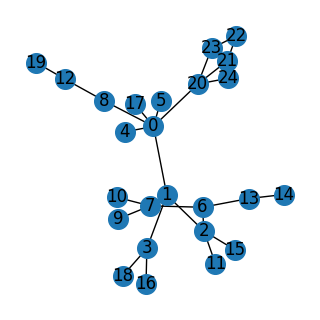

In [41]:
G = to_networkx(data, to_undirected=True)

plt.figure(figsize=(3, 3))
nx.draw(G, with_labels=True, cmap="coolwarm", node_size=200)
plt.show()

In [72]:
from gin import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GIN(
        in_channels=dataset.num_features,
        hidden_channels=32,
        out_channels=dataset.num_classes,
        num_layers=5,
    ).to(device)
model.load_state_dict(torch.load('model.pth'))
model.eval()

GIN(
  (convs): ModuleList(
    (0): GINConv(nn=MLP(10, 32, 32))
    (1-4): 4 x GINConv(nn=MLP(32, 32, 32))
  )
  (mlp): MLP(32, 32, 2)
)

In [83]:
import torch
from torch_geometric.data import Data

from torch_geometric.data import Batch

@torch.no_grad()
def predict_single_graph(model, graph, device):
    model.eval()
    
    # Tạo batch giả (dù chỉ có 1 graph)
    graph.batch = torch.zeros(graph.x.size(0), dtype=torch.long)  # Tất cả node thuộc batch 0
    batch = Batch.from_data_list([graph]).to(device)

    # Forward qua mô hình
    out = model(batch.x, batch.edge_index, batch.batch, batch_size=1)
    
    # Lấy nhãn dự đoán
    predicted_label = out.argmax(dim=-1).item()
    
    return predicted_label

def generate_modified_graphs(graph, model, device, num_graphs=50):
    modified_graphs = []
    num_nodes = graph.x.size(0)

    for _ in range(num_graphs):
        edge_index = graph.edge_index.clone()
        edges = edge_index.t().tolist()

        mode = "add" if torch.rand(1).item() > 0.5 else "remove"

        if mode == "remove" and len(edges) > 0:
            remove_idx = torch.randint(0, len(edges), (1,)).item()
            edges.pop(remove_idx)

        elif mode == "add":
            while True:
                u, v = torch.randint(0, num_nodes, (2,)).tolist()
                if u != v and [u, v] not in edges and [v, u] not in edges:
                    edges.append([u, v])
                    break

        new_edge_index = torch.tensor(edges, dtype=torch.long).t()

        # Dự đoán nhãn mới cho đồ thị đã sửa đổi
        new_graph = Data(x=graph.x, edge_index=new_edge_index)
        new_graph.y = torch.tensor([predict_single_graph(model, new_graph, device)], dtype=torch.long)

        modified_graphs.append(new_graph)

    return modified_graphs

# Ví dụ sử dụng
x = data.x
edge_index = data.edge_index
y = data.y

graph = Data(x=x, edge_index=edge_index, y=y)
modified_graphs = generate_modified_graphs(graph, model, device, num_graphs=100)



In [84]:
y_0 = 0
y_1 = 0
for graph in modified_graphs:
    y_0 += (graph.y == 0).item()
    y_1 += (graph.y == 1).item()
    
print(f"Số lượng đồ thị có nhãn 0: {y_0}")
print(f"Số lượng đồ thị có nhãn 1: {y_1}")

Số lượng đồ thị có nhãn 0: 12
Số lượng đồ thị có nhãn 1: 88


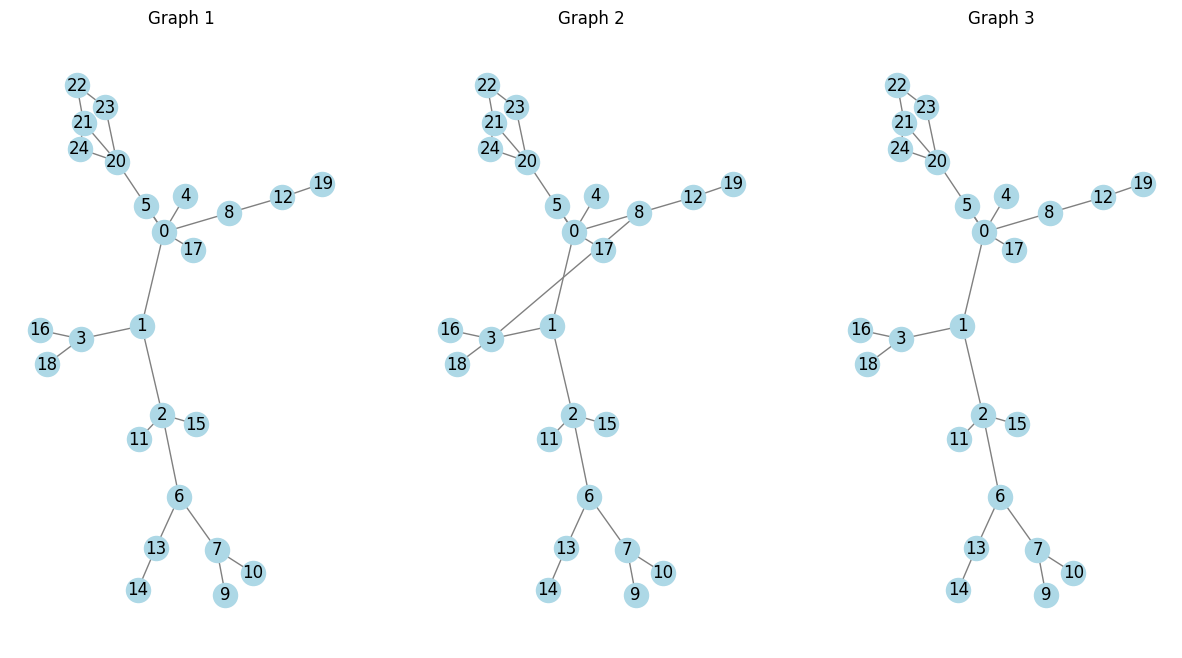

In [61]:
G_base = to_networkx(graph, to_undirected=True)
pos = nx.spring_layout(G_base, seed=42)  # Dùng layout cố định

# Vẽ đồ thị
fig, axes = plt.subplots(1, 3, figsize=(15, 8))

for i, g in enumerate(modified_graphs[:3]):
    G = to_networkx(g, to_undirected=True)
    ax = axes[i]
    ax.set_title(f"Graph {i+1}")
    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", ax=ax)

plt.show()

In [ ]:
@torch.no_grad()
def predict_single_graph(model, graph, device):
    model.eval()
    
    # Tạo batch giả (dù chỉ có 1 graph)
    graph.batch = torch.zeros(graph.x.size(0), dtype=torch.long)  # Tất cả node thuộc batch 0
    batch = Batch.from_data_list([graph]).to(device)

    # Forward qua mô hình
    out = model(batch.x, batch.edge_index, batch.batch, batch_size=1)
    
    # Lấy nhãn dự đoán
    predicted_label = out.argmax(dim=-1).item()
    
    return predicted_label

for graph in modified_graphs:
    predicted_label = predict_single_graph(model, graph, device)
    print(f"Predicted label: {predicted_label}")

Predicted label: 1
Predicted label: 1
Predicted label: 1
Predicted label: 1
Predicted label: 1
Predicted label: 1
Predicted label: 1
Predicted label: 1
Predicted label: 1
Predicted label: 1


In [85]:
from torch_geometric.data import DataLoader

data_loader = DataLoader(modified_graphs, batch_size=32, shuffle=False)
df = get_mean_node_embeddings_df(model, device, data_loader)
print(df)

      node_0    node_1    node_2    node_3    node_4    node_5    node_6  \
0   0.302913  0.007685  0.037382  0.087624  0.022363  0.022363  0.125343   
1   0.302913  0.007679  0.048527  0.087624  0.022363  0.022363  0.193867   
2   0.040916  0.007658  0.052998  0.087174  0.021025  0.021025  0.174148   
3   0.305806  0.007293  0.088131  0.084488  0.022701  0.022701  0.161443   
4   0.267474  0.136534  0.294332  0.151129  0.022999  0.022999  0.391154   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.079109  0.007866  0.053702  0.087624  0.021906  0.021906  0.174148   
96  0.300708  0.009432  0.069574  0.102911  0.022406  0.022406  0.174383   
97  0.309047  0.008021  0.051022  0.085660  0.022083  0.022083  0.173247   
98  0.240185  0.019797  0.059083  0.092908  0.026823  0.035724  0.174954   
99  0.391925  0.010330  0.053149  0.087556  0.024258  0.024258  0.173247   

      node_7    node_8    node_9  ...   node_16   node_17   node_18   node_19  \
0   0.

/Users/admin/Documents/Screenshots/LORE/.env/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [108]:
import pickle

def load_graphs_from_pickle(filename = "graph2X.pkl"):
    with open(filename, "rb") as f:
        return pickle.load(f)

loaded_graphs = load_graphs_from_pickle("graph2X.pkl")


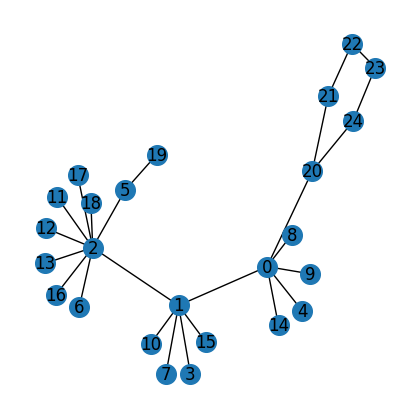

In [109]:
G = to_networkx(loaded_graphs, to_undirected=True)
plt.figure(figsize=(4, 4))
nx.draw(G, with_labels=True, cmap="coolwarm", node_size=200)
plt.show()

In [100]:
x = loaded_graphs.x
edge_index = loaded_graphs.edge_index
y = loaded_graphs.y

graph = Data(x=x, edge_index=edge_index, y=y)
modified_graphs = generate_modified_graphs(graph, model, device, num_graphs=100)


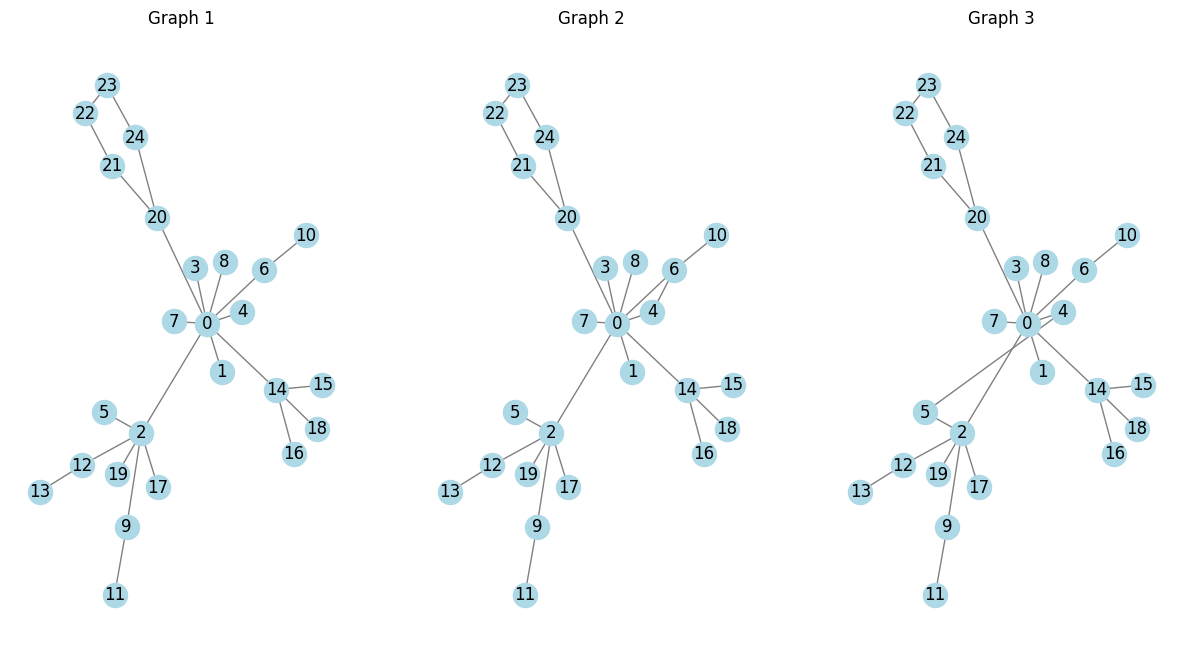

In [101]:
G_base = to_networkx(graph, to_undirected=True)
pos = nx.spring_layout(G_base, seed=42)  # Dùng layout cố định

# Vẽ đồ thị
fig, axes = plt.subplots(1, 3, figsize=(15, 8))

for i, g in enumerate(modified_graphs[:3]):
    G = to_networkx(g, to_undirected=True)
    ax = axes[i]
    ax.set_title(f"Graph {i+1}")
    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", ax=ax)

plt.show()